In [1]:
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hc


In [2]:
#https://stackoverflow.com/questions/17211078/how-to-temporarily-modify-sys-path-in-python
#the above link is where i got this code.
#sys.path is restored to original state, after execution of the with statement
#importing sklearn from my directory INSTEAD of /public/apps/etc.etc. because mine is recent version
#apparently, this is called a context manager, visit above link for more explanation
import sys

class add_path():
    def __init__(self, path):
        self.path = path

    def __enter__(self):
        sys.path.insert(0, self.path)

    def __exit__(self, exc_type, exc_value, traceback):
        try:
            sys.path.remove(self.path)
        except ValueError:
            pass
with add_path('/home/hshadman/.local/lib/python3.7/site-packages'):
    sklearn = __import__('sklearn')

In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.svm import SVC


dgene = pd.read_csv('CCLE_integrins_expression_classification.csv', sep=r'\t',engine='python')
dgene.fillna(method='ffill',inplace=True)
dinfo = pd.read_csv('sample_info.csv',engine='python')

#Get rid of integrin binding proteins
dgene = dgene.drop(["ITGB1BP2 (26548)","ITGB1BP1 (9270)","ITGB3BP (23421)"],axis=1)


In [7]:
dinfo['Class'] = where((dinfo['lineage']=='breast')&(dinfo['primary_or_metastasis']=='Primary'),True,False)

In [48]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', pd_max_rows)
#pd.set_option('display.max_columns', pd_max_columns)
#pd_max_rows=pd.options.display.max_rows
#pd_max_columns=pd.options.display.max_columns

In [57]:
dgene.columns[1:]
#dinfo[['lineage','primary_or_metastasis','Class']]
#pd.merge(dgene,dinfo,how="left",on=["DepMap_ID"])

Index(['ITGAL (3683)', 'ITGA3 (3675)', 'ITGA2B (3674)', 'ITGA8 (8516)',
       'ITGB5 (3693)', 'ITGAE (3682)', 'ITGA6 (3655)', 'ITGB8 (3696)',
       'ITGB6 (3694)', 'ITGA4 (3676)', 'ITGB4 (3691)', 'ITGA7 (3679)',
       'ITGA11 (22801)', 'ITGAV (3685)', 'ITGB7 (3695)', 'ITGAX (3687)',
       'ITGA10 (8515)', 'ITGA9 (3680)', 'ITGB1 (3688)', 'ITGAD (3681)',
       'ITGB2 (3689)', 'ITGA5 (3678)', 'ITGA2 (3673)', 'ITGAM (3684)',
       'ITGBL1 (9358)', 'ITGA1 (3672)', 'ITGB3 (3690)'],
      dtype='object')

In [32]:
##This is the original classifier from Dr. Cheng.
## It creates a new 'Class' composed of a lineage and primary/metastasis combination
##  and predicts if a cell type will be a member of this class.
##  It uses all ~1400 cancer cells to make a prediction.
def rf_classifier(dgene,dinfo,sel='lineage',lineage_sel='breast',ptype='Primary'):
    gene_id = dgene.columns[1:]
    dinfo['Class'] = where((dinfo[sel]==lineage_sel)&(dinfo['primary_or_metastasis']==ptype),True,False)
    df = pd.merge(dgene,dinfo,how="left",on=["DepMap_ID"])
    #if lineage_sel == 'engineered_lung':
    #    print(df)
    X = df[gene_id]
    y = df['Class']
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    #print(y_pred,y_test)
    print("Total number of cases in positive class:",df.query("Class").shape[0])
    print("For %s %s rfc classifier Accuracy: "%(lineage_sel,ptype), accuracy_score(y_test,y_pred))
    feature_importances_df = pd.DataFrame({"feature": list(X.columns),"importance": classifier.feature_importances_}).sort_values("importance",ascending=False)
    print(feature_importances_df)
    ax = plt.gca()
    RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax, alpha=0.8)
    plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
    plt.show()   


Total number of cases in positive class: 28
For breast Primary rfc classifier Accuracy:  0.9736263736263736
           feature  importance
8     ITGB6 (3694)    0.137048
5     ITGAE (3682)    0.061622
25    ITGA1 (3672)    0.050619
10    ITGB4 (3691)    0.048620
2    ITGA2B (3674)    0.048447
6     ITGA6 (3655)    0.048188
23    ITGAM (3684)    0.043698
0     ITGAL (3683)    0.043161
13    ITGAV (3685)    0.040839
22    ITGA2 (3673)    0.038056
14    ITGB7 (3695)    0.035419
21    ITGA5 (3678)    0.035038
1     ITGA3 (3675)    0.032370
9     ITGA4 (3676)    0.032352
17    ITGA9 (3680)    0.032234
4     ITGB5 (3693)    0.030944
26    ITGB3 (3690)    0.030689
18    ITGB1 (3688)    0.030518
20    ITGB2 (3689)    0.029972
16   ITGA10 (8515)    0.026707
24   ITGBL1 (9358)    0.025426
7     ITGB8 (3696)    0.025279
12  ITGA11 (22801)    0.022939
11    ITGA7 (3679)    0.022744
15    ITGAX (3687)    0.017960
3     ITGA8 (8516)    0.006153
19    ITGAD (3681)    0.002956


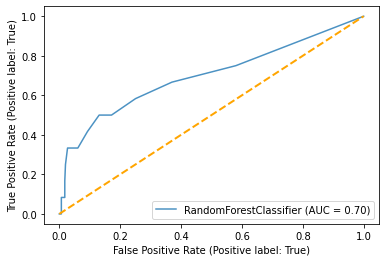

Total number of cases in positive class: 33
For breast Metastasis rfc classifier Accuracy:  0.989010989010989
           feature  importance
10    ITGB4 (3691)    0.089812
0     ITGAL (3683)    0.076893
4     ITGB5 (3693)    0.062110
7     ITGB8 (3696)    0.061294
9     ITGA4 (3676)    0.054012
16   ITGA10 (8515)    0.051862
21    ITGA5 (3678)    0.048822
25    ITGA1 (3672)    0.047677
18    ITGB1 (3688)    0.045888
1     ITGA3 (3675)    0.040605
22    ITGA2 (3673)    0.039451
26    ITGB3 (3690)    0.038182
8     ITGB6 (3694)    0.036493
6     ITGA6 (3655)    0.031987
20    ITGB2 (3689)    0.031189
13    ITGAV (3685)    0.030840
14    ITGB7 (3695)    0.028961
2    ITGA2B (3674)    0.027178
15    ITGAX (3687)    0.025786
24   ITGBL1 (9358)    0.023372
11    ITGA7 (3679)    0.022594
12  ITGA11 (22801)    0.019115
23    ITGAM (3684)    0.018815
17    ITGA9 (3680)    0.014949
5     ITGAE (3682)    0.014863
3     ITGA8 (8516)    0.011560
19    ITGAD (3681)    0.005688


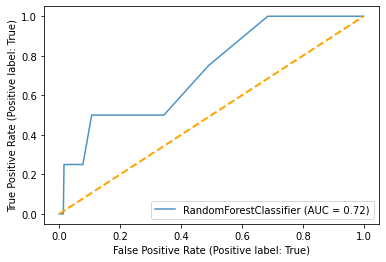

In [33]:
rf_classifier(dgene,dinfo,sel='lineage',lineage_sel='breast',ptype='Primary')
rf_classifier(dgene,dinfo,sel='lineage',lineage_sel='breast',ptype='Metastasis')

In [10]:
##This is the original classifier, but without using a test and training set.
##The model is learned from the entire data set, and the predictions are made for the same data.
##This might be useful to look for identifying the most relevant features.
## It creates a new 'Class' composed of a lineage and primary/metastasis combination
##  and predicts if a cell type will be a member of this class.
##  It uses all ~1400 cancer cells to make a prediction.
def rf_classifier_no_test_train(dgene,dinfo,sel='lineage',lineage_sel='breast',ptype='Primary'):
    gene_id = dgene.columns[1:]
    dinfo['Class'] = where((dinfo[sel]==lineage_sel)&(dinfo['primary_or_metastasis']==ptype),True,False)
    df = pd.merge(dgene,dinfo,how="left",on=["DepMap_ID"])
    #if lineage_sel == 'engineered_lung':
    #    print(df)
    X = df[gene_id]
    y = df['Class']
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(X,y)
    y_pred = classifier.predict(X)
    print()
    #print(y_pred,y_test)
    print("Total number of cases in positive class:",df.query("Class").shape[0])
    print("For %s %s rfc classifier Accuracy: "%(lineage_sel,ptype), accuracy_score(y,y_pred))
    feature_importances_df = pd.DataFrame({"feature": list(X.columns),"importance": classifier.feature_importances_}).sort_values("importance",ascending=False)
    print(feature_importances_df)
    ax = plt.gca()
    RocCurveDisplay.from_estimator(classifier, X, y, ax=ax, alpha=0.8)
    plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
    plt.show()   


Total number of cases in positive class: 28
For breast Primary rfc classifier Accuracy:  1.0
           feature  importance
8     ITGB6 (3694)    0.105460
22    ITGA2 (3673)    0.052398
5     ITGAE (3682)    0.051366
10    ITGB4 (3691)    0.047001
2    ITGA2B (3674)    0.045793
21    ITGA5 (3678)    0.045487
25    ITGA1 (3672)    0.044709
0     ITGAL (3683)    0.043643
9     ITGA4 (3676)    0.042496
17    ITGA9 (3680)    0.039629
24   ITGBL1 (9358)    0.038222
4     ITGB5 (3693)    0.038049
16   ITGA10 (8515)    0.034533
13    ITGAV (3685)    0.033632
26    ITGB3 (3690)    0.032341
18    ITGB1 (3688)    0.032258
11    ITGA7 (3679)    0.031033
14    ITGB7 (3695)    0.030487
6     ITGA6 (3655)    0.029960
1     ITGA3 (3675)    0.028857
23    ITGAM (3684)    0.028682
20    ITGB2 (3689)    0.028651
12  ITGA11 (22801)    0.028216
7     ITGB8 (3696)    0.027870
15    ITGAX (3687)    0.018208
3     ITGA8 (8516)    0.016819
19    ITGAD (3681)    0.004200


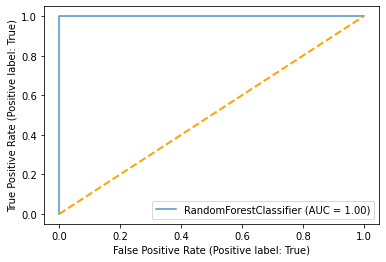


Total number of cases in positive class: 33
For breast Metastasis rfc classifier Accuracy:  1.0
           feature  importance
10    ITGB4 (3691)    0.074093
4     ITGB5 (3693)    0.072082
7     ITGB8 (3696)    0.060921
0     ITGAL (3683)    0.055358
18    ITGB1 (3688)    0.053978
8     ITGB6 (3694)    0.053859
25    ITGA1 (3672)    0.051429
21    ITGA5 (3678)    0.048381
9     ITGA4 (3676)    0.047397
1     ITGA3 (3675)    0.045816
16   ITGA10 (8515)    0.043839
6     ITGA6 (3655)    0.038023
2    ITGA2B (3674)    0.035195
26    ITGB3 (3690)    0.031623
20    ITGB2 (3689)    0.030890
11    ITGA7 (3679)    0.028718
13    ITGAV (3685)    0.026569
14    ITGB7 (3695)    0.026246
12  ITGA11 (22801)    0.026156
15    ITGAX (3687)    0.025343
22    ITGA2 (3673)    0.023001
24   ITGBL1 (9358)    0.022156
23    ITGAM (3684)    0.021473
17    ITGA9 (3680)    0.017996
5     ITGAE (3682)    0.017127
3     ITGA8 (8516)    0.011792
19    ITGAD (3681)    0.010538


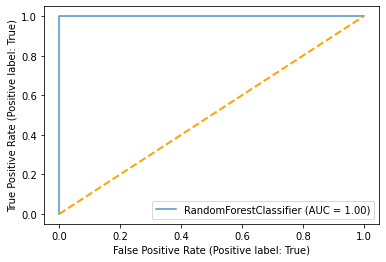

In [11]:
rf_classifier_no_test_train(dgene,dinfo,sel='lineage',lineage_sel='breast',ptype='Primary')
rf_classifier_no_test_train(dgene,dinfo,sel='lineage',lineage_sel='breast',ptype='Metastasis')

In [ ]:
##This looks at one tissue and tries to classify the cell types as primary or metastasis
def rf_classifier_single_tissue(dgene,dinfo,sel='lineage',lineage_sel='breast'):
    gene_id = dgene.columns[1:]
    df = pd.merge(dgene,dinfo,how="left",on=["DepMap_ID"])
    df = df[df[sel]==lineage_sel]
    df = df[df["primary_or_metastasis"].notna()]
    X = df[gene_id]
    y = df['primary_or_metastasis']
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    #print(y_pred,y_test)
    print("Total number of cell types for tissue:",df.shape[0])
    print("For %s rfc classifier Accuracy: "%lineage_sel, accuracy_score(y_test,y_pred))
    feature_importances_df = pd.DataFrame({"feature": list(X.columns),"importance": classifier.feature_importances_}).sort_values("importance",ascending=False)
    print(feature_importances_df)
    ax = plt.gca()
    RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax, alpha=0.8)
    plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
    plt.show()     

In [ ]:
rf_classifier_single_tissue(dgene,dinfo,sel='lineage',lineage_sel='breast')

In [ ]:
def rf_classifier_single_tissue_no_test_train(dgene,dinfo,sel='lineage',lineage_sel='breast'):
    gene_id = dgene.columns[1:]
    df = pd.merge(dgene,dinfo,how="left",on=["DepMap_ID"])
    df = df[df[sel]==lineage_sel]
    df = df[df["primary_or_metastasis"].notna()]
    X = df[gene_id]
    y = df['primary_or_metastasis']
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(X,y)
    y_pred = classifier.predict(X)
    #print(y_pred,y_test)
    print("Total number of cell types for tissue:",df.shape[0])
    print("For %s rfc classifier Accuracy: "%lineage_sel, accuracy_score(y,y_pred))
    feature_importances_df = pd.DataFrame({"feature": list(X.columns),"importance": classifier.feature_importances_}).sort_values("importance",ascending=False)
    print(feature_importances_df)
    ax = plt.gca()
    RocCurveDisplay.from_estimator(classifier, X, y, ax=ax, alpha=0.8)
    plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
    plt.show()  

In [ ]:
rf_classifier_single_tissue_no_test_train(dgene,dinfo,sel='lineage',lineage_sel='breast')


In [ ]:
##This looks at one tissue and tries to classify the cell types as primary or metastasis
def rf_classifier_all_cells(dgene,dinfo):
    gene_id = dgene.columns[1:]
    df = pd.merge(dgene,dinfo,how="left",on=["DepMap_ID"])
#    df = df[df[sel]==lineage_sel]
    df = df[df["primary_or_metastasis"].notna()]
    X = df[gene_id]
    y = df['primary_or_metastasis']
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    #print(y_pred,y_test)
    print("Total number of cell types for tissue:",df.shape[0])
    print("For all cells, rfc classifier Accuracy: ", accuracy_score(y_test,y_pred))
    feature_importances_df = pd.DataFrame({"feature": list(X.columns),"importance": classifier.feature_importances_}).sort_values("importance",ascending=False)
    print(feature_importances_df)
    ax = plt.gca()
    RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax, alpha=0.8)
    plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
    plt.show()   

In [ ]:
rf_classifier_all_cells(dgene,dinfo)

In [ ]:
##This uses all of the data and tries to classify based on the lineage
## It ignores primary or metastasis
def rf_classifier_tissue(dgene,dinfo,sel='lineage',lineage_sel='breast'):
    gene_id = dgene.columns[1:]
    dinfo['Class'] = where((dinfo[sel]==lineage_sel),True,False)
    df = pd.merge(dgene,dinfo,how="left",on=["DepMap_ID"])
    #if lineage_sel == 'engineered_lung':
    #    print(df)
    X = df[gene_id]
    y = df['Class']
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    #print(y_pred,y_test)
    print("Total number of cases in positive class:",df.query("Class").shape[0])
    print("For %s rfc classifier Accuracy: "%lineage_sel, accuracy_score(y_test,y_pred))
    feature_importances_df = pd.DataFrame({"feature": list(X.columns),"importance": classifier.feature_importances_}).sort_values("importance",ascending=False)
    print(feature_importances_df)
    ax = plt.gca()
    RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax, alpha=0.8)
    plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
    plt.show()   

In [ ]:
rf_classifier_tissue(dgene,dinfo,sel='lineage',lineage_sel='breast')

In [ ]:
##This tries to classify based on the lineage
## It looks at only a single ptype. Either only the primary cells are used or only the metastatic cells are used.
def rf_classifier_single_ptype(dgene,dinfo,sel='lineage',lineage_sel='breast',ptype='Primary'):
    gene_id = dgene.columns[1:]
    dinfo['Class'] = where((dinfo[sel]==lineage_sel),True,False)
    df = pd.merge(dgene,dinfo,how="left",on=["DepMap_ID"])
    df = df[df["primary_or_metastasis"]==ptype]
    #if lineage_sel == 'engineered_lung':
    #    print(df)
    X = df[gene_id]
    y = df['Class']
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100)
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    #print(y_pred,y_test)
    print("Total number of cases in positive class:",df.query("Class").shape[0])
    print("For %s %s rfc classifier Accuracy: "%(lineage_sel,ptype), accuracy_score(y_test,y_pred))
    feature_importances_df = pd.DataFrame({"feature": list(X.columns),"importance": classifier.feature_importances_}).sort_values("importance",ascending=False)
    print(feature_importances_df)
    ax = plt.gca()
    RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax, alpha=0.8)
    plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
    plt.show()   

In [ ]:
rf_classifier_single_ptype(dgene,dinfo,sel='lineage',lineage_sel='breast',ptype='Primary')
rf_classifier_single_ptype(dgene,dinfo,sel='lineage',lineage_sel='breast',ptype='Metastasis')